In [83]:
import pandas as pd
import numpy as np
from parameter_estimator import ParameterEstimator as pe
import utils
from collections import deque
import cv2
import random
import math as m
from itertools import combinations
import pickle
import datetime
import matplotlib.pyplot as plt

In [92]:
# functions to convert from and to spherical coordinates
def asSpherical(x, y, z):
    r = m.sqrt(x*x + y*y + z*z)
    theta = m.acos(z/r)*180 / m.pi  # to degrees
    phi = m.atan2(y, x)*180 / m.pi
    return r, theta, phi


def asCartesian(r, theta, phi):
    theta = theta * m.pi/180  # to radian
    phi = phi * m.pi/180
    x = r * m.sin(theta) * m.cos(phi)
    y = r * m.sin(theta) * m.sin(phi)
    z = r * m.cos(theta)
    return x, y, z

In [93]:
# generate the poses of markers
ids = list(range(30))  # marker ids to use
dict_T_WM = {}

for marker_id in ids:  # generate random poses for virtual markers
    r = np.random.normal(3, 0.12, 1)[0]
    theta = np.random.uniform(0, 90, 1)[0]
    phi   = np.random.uniform(0, 360, 1)[0]
    x, y, z = asCartesian(r, theta, phi)
    dict_T_WM[marker_id]= utils.H_rvec_tvec(np.array([0.0, 0, 0]), np.array([x, y, z]))


In [94]:
# generate robot configurations

# import trajectory
traj_file="/home/armin/catkin_ws/src/kident2/src/traj.csv"
try:
    df = pd.read_csv(traj_file)
except Exception as e:
    print(e)
traj = df.to_numpy()  # shape: (num_joints, num_traj_points)
traj = traj[:, 1:]  # delete header
traj = traj.T

In [95]:
# import robot values
theta_all = pe.dhparams["theta_nom"]
d_all = pe.dhparams["d_nom"]
r_all = pe.dhparams["r_nom"]
alpha_all = pe.dhparams["alpha_nom"]

T_corr = pe.T_corr
T_W0 = pe.T_W0

In [99]:
# create the data structure for observations
dict_observations = {}
for marker in ids:
    dict_observations[marker] = []

list_camera_pos = []
num_obs = 0
    
# generate pseudo measurement data
for q in traj:
    q = np.concatenate((q, np.zeros(1)))  # add an extra coordinate for camera frame
    
    # choose 40 random markers for this configuration
    markers = random.choices(ids, k=6)
    
    for marker in markers:
        T_WM = dict_T_WM[marker]
        T_08 = pe.get_T_jk(0, 8, q, theta_all, d_all, r_all, alpha_all)
        T_W8 = T_W0 @ T_08
        list_camera_pos.append(T_W8[0:3,3])
        T_CM = np.linalg.inv(T_08) @ np.linalg.inv(T_W0) @ T_WM
        T_CM_uncorr = np.linalg.inv(T_corr) @ T_CM @ T_corr
        # add error to the measurement
        error_t = np.random.rand(3)
        error_translate = 0.5  # mm
        error_rotate = 0.5  # degree
        error_t = np.divide(error_t, np.linalg.norm(error_t)*1000)*error_translate
        error_r = np.random.rand(3)
        error_r = np.divide(error_r, np.linalg.norm(error_r)/360*np.pi)*error_rotate
        error_transform = utils.H_rvec_tvec(error_r,error_t)
        rvec, tvec = utils.mat2rvectvec(T_CM_uncorr@error_transform)
        
        # check
        # T_CM_check = T_corr @ utils.H_rvec_tvec(rvec, tvec) @ np.linalg.inv(T_corr)
        # T_WM__check = T_W0 @ T_08 @ T_CM_check
        # utils.roundprint(T_CM - T_CM_check)
        
        obs = {}
        obs['id'] = marker
        obs['rvec'] = rvec
        obs['tvec'] = tvec
        obs['t'] = 0
        obs['q'] = q.flatten()
        dict_observations[marker].append(obs)
        num_obs = num_obs + 1
        
# check if for each marker there are at least three observations
dict_observations = {i:dict_observations[i] for i in dict_observations if len(dict_observations[i])>3}
        

In [100]:
# save the observations into a pickle file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
observations_file_str = f'observations_simulated_w_error_{error_translate}mm_{error_rotate}deg_num{num_obs}' + timestamp + '.p'
print(observations_file_str)
observations_file = open(observations_file_str, 'wb')
pickle.dump(dict_observations, observations_file)
observations_file.close()


observations_simulated_w_error_0.5mm_0.5deg_num24020231020_164948.p


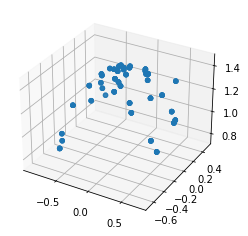

In [101]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = []
x = []
y = []
for point in list_camera_pos:
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])
 
ax.scatter(x, y, z)
plt.show()